#  Neural-Network-based Equalization in Channels with Intersymbol-Interference

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* Transmission over an ISI channel and time-domain equalization
* Training a nonlinear equalizer using the minimum mean squared error (MMSE) criterion and using it with a neural-network based demapper
* Jointly training a nonlinear equalizer and a neural-network-based demapper
* Jointly training a nonlinear equalizer and a standard demapper assuming a Gaussian distribution

This notebook is inspired by [1].

[1] F. Diedolo, G. Böcherer, M. Schädler, S. Calabro, "Nonlinear Equalization for Optical Communications Based on Entropy-Regularized Mean Square Error," preprint https://arxiv.org/pdf/2206.01004.pdf

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


We consider transmission over a linear channel characterized by its impulse response $\boldsymbol{h} = \begin{pmatrix} h_0 & h_1 & \cdots & h_{L-1}\end{pmatrix}$ and subject to complex additive white Gaussian noise (AWGN). Let $t_i$ be the sequence of transmit symbols, with $t_i \in\mathcal{M}$ ($\mathcal{M}$ being the constellation), the channel output is given by
$$
r_i = \sum_{j=0}^{L-1}h_j t_{i-j} + n_i
$$
with $n_i \sim\mathcal{CN}(0,\sigma_n^2)$.

In [2]:
constellations = {'16-QAM': np.array([-3,-3,-3,-3,-1,-1,-1,-1,1,1,1,1,3,3,3,3]) + 1j*np.array([-3,-1,1,3,-3,-1,1,3,-3,-1,1,3,-3,-1,1,3]), \
                  '16-APSK': np.array([1,-1,0,0,1.4,1.4,-1.4,-1.4,3,-3,0,0,5,-5,0,0]) + 1j*np.array([0,0,1,-1,1.4,-1.4,1.4,-1.4,0,0,4,-4,0,0,6,-6])}

# channel impulse response, Proakis A channel
h_ch = np.array( [0.04, -0.05, 0.07, -0.21, -0.5, 0.72, 0.36, 0.0, 0.21, 0.03, 0.07] )

# choose constellation
con = '16-QAM'

# normalize channel impulse response
h_ch = h_ch / np.sqrt(np.sum(np.square(h_ch)))


# permute constellations so that it is visually more appealing with the chosen colormap
# additionally normalize constellations so that transmit symbol has unit energy
for cname in constellations.keys():
    constellations[cname] = constellations[cname][np.random.permutation(len(constellations[cname]))]
    constellations[cname] /= np.sqrt(np.mean(np.square(np.abs(constellations[cname]))))

    
# simulate the channel    
def simulate_channel(x, h, EsN0_dB):  
    EsN0_lin = 10.0 ** (EsN0_dB / 10.0)
    sigma_n = np.sqrt( 0.5 / EsN0_lin )
    
    xt = np.convolve(x, h)
    
    return xt + sigma_n * ( np.random.randn(len(xt)) + 1j*np.random.randn(len(xt)) )

Function preparing a mini-batch. Each element of the mini-batch is a sequence of length $S$ and corresponds to one transmit symbol. We return both the channel input sequence, the mini-batch sequence and the transmit symbol index (as well as the corresponding one-hot representation). As we cannot easily handle complex numbers, we concatenate real and imaginary parts.

In [3]:
def prepare_minibatch(constellation, h, EsN0_dB, batch_size, seq_length):
    # generate random symbols
    t = np.random.randint(len(constellation), size=seq_length + (batch_size - 1) + (len(h)-1) )
    x = constellation[t]
    
    # simulate the channel with impulse response h and EsN0
    y = simulate_channel(x, h, EsN0_dB)
    
    # throw away first and last samples (ringing artifacts)
    y = y[(len(h)-1):-(len(h)-1)]
    
    # convert to PyTorch data and extract both real and imaginary part
    y_torch_re = torch.from_numpy(np.real(y)).float().to(device)
    y_torch_im = torch.from_numpy(np.imag(y)).float().to(device)

    # Use the unfold command to generate the sliding window sequence
    y_torch_re = y_torch_re.unfold(dimension=0, size=seq_length, step=1 )
    y_torch_im = y_torch_im.unfold(dimension=0, size=seq_length, step=1 )
    
    # stack real and imaginary part
    y_torch = torch.hstack( (y_torch_re, y_torch_im) )
    
    # generate reference sequence    
    half_len = seq_length // 2
    
    # cut midpoint symbols in sequence (throw away first and last symbols)
    t_cut = t[(len(h)-1 + half_len) + np.arange(batch_size)]
    x_cut = x[(len(h)-1 + half_len) + np.arange(batch_size)]
    
    # convert modulation symbols into PyTorch data structure
    x_torch_re = torch.from_numpy(np.real(x_cut)).float().to(device)
    x_torch_im = torch.from_numpy(np.imag(x_cut)).float().to(device)
    
    # stack real and imaginary parts        
    x_torch = torch.transpose(torch.vstack( (x_torch_re, x_torch_im) ), 0, 1)
       
    # convert symbols to one-hot vector
    t_torch = torch.from_numpy(t_cut).to(device)
    
    t_onehot_torch = torch.zeros(batch_size, len(constellation), device=device)
    t_onehot_torch[range(t_onehot_torch.shape[0]), t_torch.long()]=1
    
    return t_torch, t_onehot_torch, x_torch, y_torch

Test the mini-batch generation

In [4]:
t, toh, x, y = prepare_minibatch(constellations['16-QAM'], h_ch, 200, batch_size=3, seq_length=5)
print(x)
print(y)

tensor([[-0.9487,  0.3162],
        [-0.9487,  0.9487],
        [ 0.3162, -0.3162]], device='cuda:0')
tensor([[ 0.1517,  0.4931, -0.1454, -0.0316, -0.0506, -0.0695,  1.0746, -0.9609,
         -0.2339,  0.6764],
        [ 0.4931, -0.1454, -0.0316, -0.0506, -0.6321,  1.0746, -0.9609, -0.2339,
          0.6764,  0.7459],
        [-0.1454, -0.0316, -0.0506, -0.6321, -0.4299, -0.9609, -0.2339,  0.6764,
          0.7459,  0.4235]], device='cuda:0')


Implement a nonlinear equalizer using a neural network. The input is a vector of sequence length (real and imaginary part), which is then processed by two hidden layers (fully connected linear layer with ELU activation function) and finally a linear output layer with 2 outputs (real part and imaginary part)

In [5]:
class Equalizer_Network(nn.Module):
    def __init__(self, input_neurons, hidden_neurons_1, hidden_neurons_2):
        super(Equalizer_Network, self).__init__()
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(input_neurons, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()
       
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  
        
        # Output layer
        self.fc3 = nn.Linear(hidden_neurons_2, 2)
        
        

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)
        
        # Linear function, third layer
        out = self.fc3(out)
        
        return out

Train the neural network using Adam and a varying batch size.

In [6]:
EsN0_dB = 15

seq_length = len(h_ch)*3
model_eq = Equalizer_Network(seq_length*2, 50, 20)
model_eq.to(device)

# Cross Entropy loss accepting logits at input
loss_fn = nn.MSELoss()

# Adam Optimizer
optimizer = optim.Adam(model_eq.parameters())  

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        _, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        outputs = model_eq(y)
        
        # compute loss
        loss = loss_fn(outputs, x)
        
         # compute gradients
        loss.backward()
        
        optimizer.step()
        # reset gradients
        optimizer.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 0.03038207627832889556885
Epoch 10: Loss 0.02431318722665309906006
Epoch 20: Loss 0.01843457855284214019775
Epoch 30: Loss 0.01492096576839685440063
Epoch 40: Loss 0.01244764961302280426025
Epoch 50: Loss 0.01091893203556537628174
Epoch 60: Loss 0.01293704658746719360352
Epoch 70: Loss 0.01266581378877162933350
Epoch 80: Loss 0.01357118692249059677124
Epoch 90: Loss 0.01360945217311382293701


Plot the constellation after the equalizer

Text(0.5, 1.0, 'Equalized constellation')

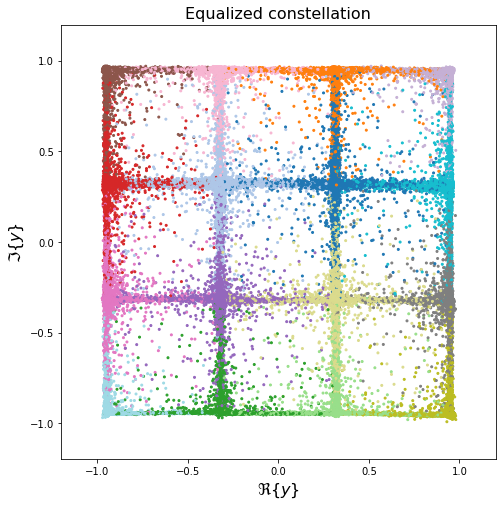

In [7]:
# Evaluate
model_eq.eval()

t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, 100000, seq_length)

f_eq = model_eq(y).cpu().detach().numpy()
r_ch = y.cpu().detach().numpy()
t_sym = t.cpu().detach().numpy()

plt.figure(figsize=(8,8))
plt.scatter(f_eq[:,0], f_eq[:,1], c=t_sym, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=16)
plt.ylabel(r'$\Im\{y\}$',fontsize=16)
plt.xlim((-1.2, 1.2))
plt.ylim((-1.2, 1.2))
plt.title('Equalized constellation',fontsize=16)


Implement a neural network-based demapper. The neural network-based demapper approximates posterior probabilities $P(t_i | y_i)$, where $y_i$ is the equalizer output, using a neural network, which outputs the approximates $Q(t_i|y_i)$. We do not need to implement the soft function, as it is already part of the network.

In [8]:
class Demapper_Network(nn.Module):
    def __init__(self, hidden_neurons_1, hidden_neurons_2, output_neurons):
        super(Demapper_Network, self).__init__()
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(2, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()
       
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  
        
        # Output layer
        self.fc3 = nn.Linear(hidden_neurons_2, output_neurons)
        
        

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)
        
        # Linear function, third layer, do not use softmax, as it is already part of the loss function
        out = self.fc3(out)
        
        return out

In [9]:
# Train demapper
model_demap = Demapper_Network(20, 30, len(constellations[con]))
model_demap.to(device)

# Cross Entropy loss accepting logits at input
loss_fn = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer_demap = optim.Adam(model_demap.parameters())  

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        # Apply equalizer
        yeq = model_eq(y)
        
        # Apply demapper
        outputs = model_demap(yeq)
        
        # compute loss        
        loss = loss_fn(outputs.squeeze(), t)
        
         # compute gradients
        loss.backward()
        
        optimizer_demap.step()
                              
        # reset gradients
        optimizer_demap.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 0.39409163594245910644531
Epoch 10: Loss 0.22712551057338714599609
Epoch 20: Loss 0.23749044537544250488281
Epoch 30: Loss 0.22187370061874389648438
Epoch 40: Loss 0.25179171562194824218750
Epoch 50: Loss 0.24241095781326293945312
Epoch 60: Loss 0.23879118263721466064453
Epoch 70: Loss 0.24757444858551025390625
Epoch 80: Loss 0.23099081218242645263672
Epoch 90: Loss 0.23089250922203063964844


Evaluate the performance over a range of $E_{\mathrm{s}}/N_0$. Calcualte both the symbol error rate and the achievable information rate, which is given by 
$$
H(\mathsf{t}) + \mathbb{E}_{\mathsf{y},\mathsf{t}}\{\log_2(Q(\mathsf{t}|\mathsf{y}))\}
$$
and we approximate the expectation using the law of large numbers and a batch. We know that $H(\mathsf{t}) = \log_2|\mathcal{M}|$.

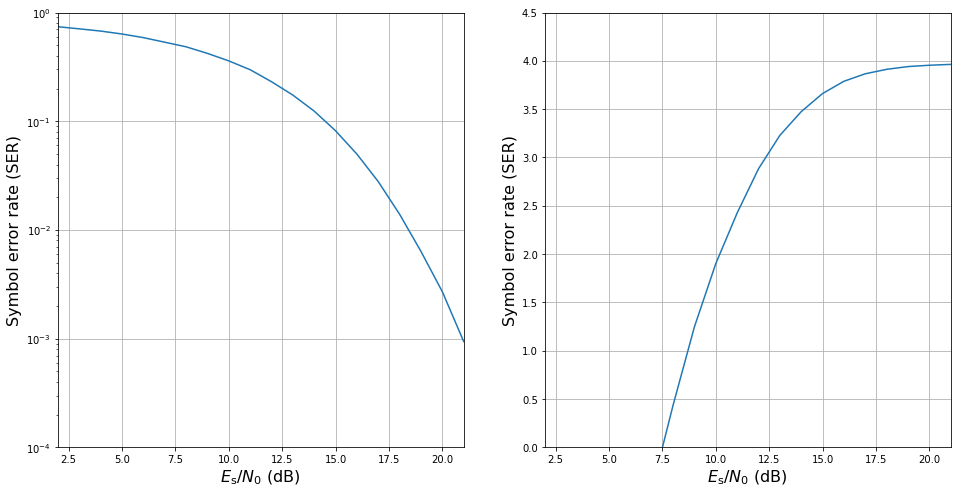

In [12]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

# Evaluate
model_eq.eval()
model_demap.eval()

softmax = nn.Softmax(dim=1)

# compute SER and mutual information over a range of EsN0

esno_range_eval = np.arange(2,22)
SER_separate = np.zeros(len(esno_range_eval))
MI_separate = np.zeros(len(esno_range_eval))

for idx,esno in enumerate(esno_range_eval):
    t, _, x, y = prepare_minibatch(constellations[con], h_ch, esno, 100000, seq_length)

    output = softmax(model_demap( model_eq(y) ))
    
    SER_separate[idx] = SER(output.detach().cpu().numpy(), t.detach().cpu().numpy())

    # compute MI
    tmp = output.detach().cpu().numpy()
    MI_separate[idx] = np.log2(len(constellations[con])) - np.mean(-np.log2(0.00000000001 + tmp[np.arange(tmp.shape[0]),t.detach().long().cpu().numpy()]))
    

   
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.semilogy(esno_range_eval, SER_separate)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((1e-4, 1))
plt.grid(which='major')

plt.subplot(122)
plt.plot(esno_range_eval, MI_separate)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((0, 4.5))
plt.grid(which='major')



---
### Comparison: Joint training of equalizer and demapper

Now, we do not train the equalizer and demapper separately, but we train them jointly. Note that minimizing the cross-entropy loss is equivalent to maximizing the esimate of the achievable information rate.

In [13]:
# Joint training
model_jeq = Equalizer_Network(seq_length*2, 50, 20)
model_jeq.to(device)

model_jdemap = Demapper_Network(20, 30, len(constellations[con]))
model_jdemap.to(device)

optimizer_joint = optim.Adam( list(model_jeq.parameters()) + list(model_jdemap.parameters()) )

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        # Apply equalizer
        yeq = model_jeq(y)
        
        # Apply demapper
        outputs = model_jdemap(yeq)
        
        # compute loss        
        loss = loss_fn(outputs.squeeze(), t)
        
         # compute gradients
        loss.backward()
        
        optimizer_joint.step()
                              
        # reset gradients
        optimizer_joint.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 0.43210643529891967773438
Epoch 10: Loss 0.23358969390392303466797
Epoch 20: Loss 0.22535611689090728759766
Epoch 30: Loss 0.22933401167392730712891
Epoch 40: Loss 0.23687915503978729248047
Epoch 50: Loss 0.21066884696483612060547
Epoch 60: Loss 0.20097418129444122314453
Epoch 70: Loss 0.22192732989788055419922
Epoch 80: Loss 0.21379524469375610351562
Epoch 90: Loss 0.21065121889114379882812


Plot the constellation after the equalizer. Attention, it can be weirdly scaled and rotated, as it is not matched to a standard demapper, but to the joint demapper obtained during the training.

Text(0.5, 1.0, 'Equalized constellation')

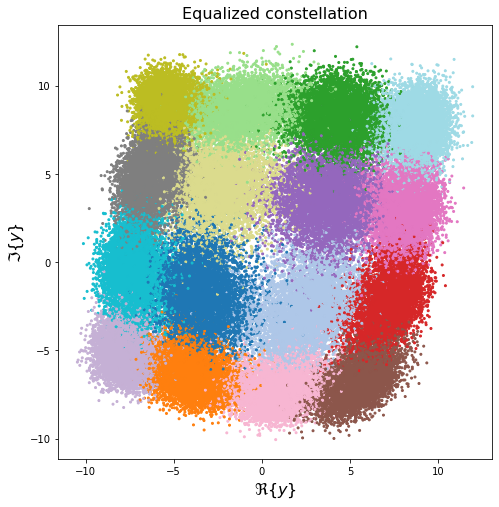

In [14]:
# Evaluate
model_jeq.eval()
model_jdemap.eval()

t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, 100000, seq_length)

f_eq = model_jeq(y).cpu().detach().numpy()
r_ch = y.cpu().detach().numpy()
t_sym = t.cpu().detach().numpy()

plt.figure(figsize=(8,8))

plt.scatter(f_eq[:,0], f_eq[:,1], c=t_sym, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=16)
plt.ylabel(r'$\Im\{y\}$',fontsize=16)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.2, 1.2))
plt.title('Equalized constellation',fontsize=16)


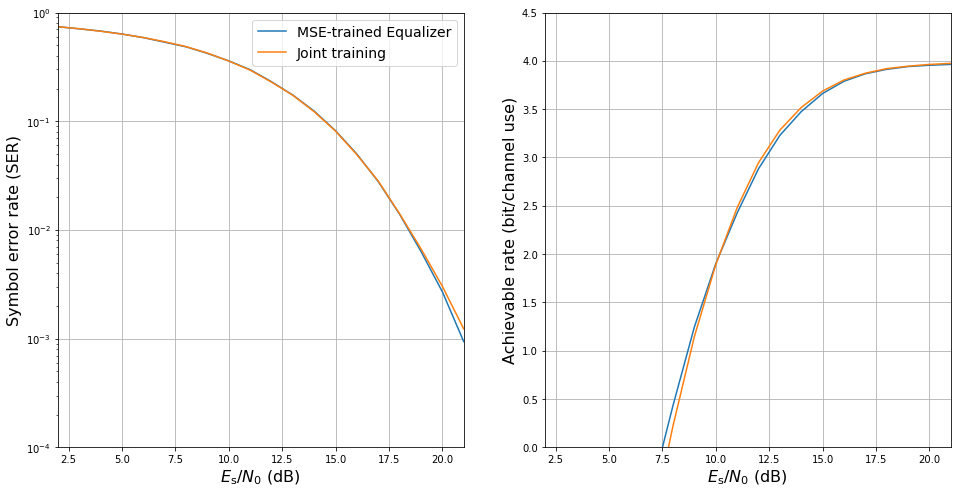

In [16]:
# Evaluate
model_jeq.eval()
model_jdemap.eval()

# compute SER and mutual information over a range of EsN0

SER_joint = np.zeros(len(esno_range_eval))
MI_joint = np.zeros(len(esno_range_eval))

for idx,esno in enumerate(esno_range_eval):
    t, _, x, y = prepare_minibatch(constellations[con], h_ch, esno, 100000, seq_length)

    output = softmax(model_jdemap( model_jeq(y) ))
    
    SER_joint[idx] = SER(output.detach().cpu().numpy(), t.detach().cpu().numpy())

    # compute MI
    tmp = output.detach().cpu().numpy()
    MI_joint[idx] = np.log2(len(constellations[con])) - np.mean(-np.log2(tmp[np.arange(tmp.shape[0]),t.detach().long().cpu().numpy()]))
    

   
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.semilogy(esno_range_eval, SER_separate)
plt.semilogy(esno_range_eval, SER_joint)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((1e-4, 1))
plt.grid(which='major')
plt.legend(['MSE-trained Equalizer','Joint training', 'Joint training (Gaussian demapper)'], fontsize=14)

plt.subplot(122)
plt.plot(esno_range_eval, MI_separate)
plt.plot(esno_range_eval, MI_joint)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Achievable rate (bit/channel use)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((0, 4.5))
plt.grid(which='major')


---
### Joint training of neural network-based equalizer and standard Gaussian demapper

Now, we replace the neural-network based demapper by a standard Gaussian demapper, which computes 
$$
Q(t_i | y_i) \propto \exp\left(-\frac{\Vert y_i - t_i\Vert^2}{2\sigma^2}\right)
$$
where $\sigma^2$ is a trainable parameter.

This trains a nonlinear equalizer that can be used in a standard communication system, as it is widely employed.

In [17]:
class Gaussian_Demapper(nn.Module):
    def __init__(self, constellation):
        super(Gaussian_Demapper, self).__init__()
        
        self.sigma_square = nn.Parameter(torch.tensor(.1), requires_grad=True)
        
        self.register_buffer('constellation_real', torch.from_numpy(np.real(constellation)) )
        self.register_buffer('constellation_imag', torch.from_numpy(np.imag(constellation)) )                

    def forward(self, x):
        x_real = torch.transpose( (x[:,0]).repeat((len(self.constellation_real), 1)), 0,1)
        x_imag = torch.transpose( (x[:,1]).repeat((len(self.constellation_real), 1)), 0,1)
        
        # calculate Euclidean distance and Gaussian function
        out = (torch.square(x_real - self.constellation_real) + torch.square(x_imag - self.constellation_imag))
        out = torch.exp(-out / 2.0 / self.sigma_square)

        # normalize       
        out = out / torch.unsqueeze(torch.sum(out, axis=1), 1)
       
        return out

Carry out the training. Note that the Gaussian demapper already computes probabilities, so here we use it together with the NLLLoss loss function, which accepts log-probabilities, so we need to take care of taking an extra logarithm.

Note that we could also output directly log probabilities, but for the sake of simplicity, we decided to keep the demapper "standard" and modify the loss function.

In [30]:
# Joint training with Gaussian demapper
model_jgeq = Equalizer_Network(seq_length*2, 50, 20)
model_jgeq.to(device)

model_jgdemap = Gaussian_Demapper(constellations[con])
model_jgdemap.to(device)

optimizer_joint_Gaussian = optim.Adam( list(model_jgeq.parameters()) + list(model_jgdemap.parameters()) )

num_epochs = 100
batches_per_epoch = 500

loss_fn_jg = nn.NLLLoss()

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        # Apply equalizer
        yeq = model_jgeq(y)
        
        # Apply Gaussian demapper
        outputs = model_jgdemap(yeq)
        
        # compute loss        
        loss = loss_fn_jg(torch.log(outputs+0.000000001), t)
        
         # compute gradients
        loss.backward()
        
        optimizer_joint_Gaussian.step()
                              
        # reset gradients
        optimizer_joint_Gaussian.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 0.37251974462653292263781
Epoch 10: Loss 0.17731823395983342672722
Epoch 20: Loss 0.24838454259777703603262
Epoch 30: Loss 0.25806994116096182434461
Epoch 40: Loss 0.21536602426106080110380
Epoch 50: Loss 0.19737354114541677541084
Epoch 60: Loss 0.22172058162662250380137
Epoch 70: Loss 0.21482764469504381232845
Epoch 80: Loss 0.19232662387756999100574
Epoch 90: Loss 0.20783392801047709252948


Text(0.5, 1.0, 'Equalized constellation')

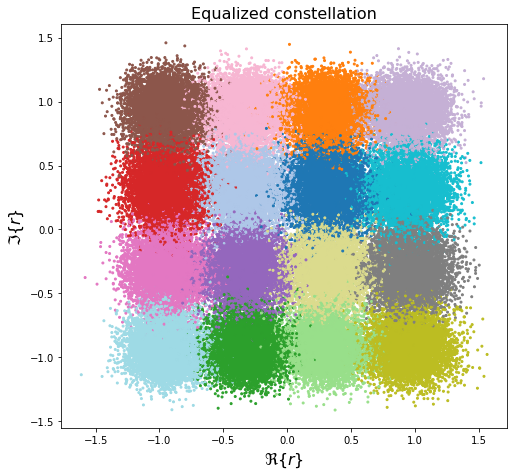

In [31]:
# Evaluate
model_jgeq.eval()
model_jgdemap.eval()

t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, 100000, seq_length)

f_eq = model_jgeq(y).cpu().detach().numpy()
r_ch = y.cpu().detach().numpy()
t_sym = t.cpu().detach().numpy()

plt.figure(figsize=(8,8))

plt.scatter(f_eq[:,0], f_eq[:,1], c=t_sym, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.2, 1.2))
plt.title('Equalized constellation',fontsize=16)


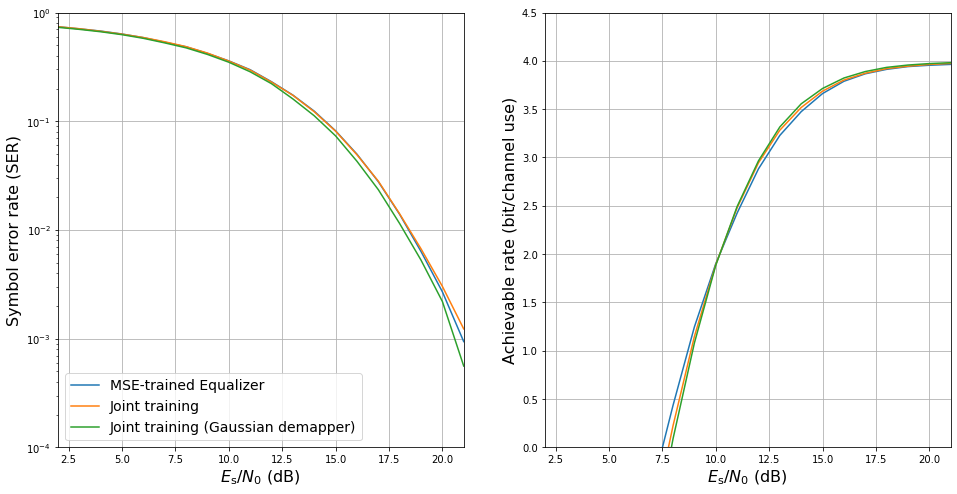

In [32]:
# Evaluate
model_jgeq.eval()
model_jgdemap.eval()

# compute SER and mutual information over a range of EsN0

SER_joint_Gaussian = np.zeros(len(esno_range_eval))
MI_joint_Gaussian = np.zeros(len(esno_range_eval))

for idx,esno in enumerate(esno_range_eval):
    t, _, x, y = prepare_minibatch(constellations[con], h_ch, esno, 100000, seq_length)

    output = model_jgdemap( model_jgeq(y) )   # outputs probabilities
    
    SER_joint_Gaussian[idx] = SER(output.detach().cpu().numpy(), t.detach().cpu().numpy())

    # compute MI
    tmp = output.detach().cpu().numpy()
    MI_joint_Gaussian[idx] = np.log2(len(constellations[con])) - np.mean(-np.log2(tmp[np.arange(tmp.shape[0]),t.detach().long().cpu().numpy()]))
    

   
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.semilogy(esno_range_eval, SER_separate)
plt.semilogy(esno_range_eval, SER_joint)
plt.semilogy(esno_range_eval, SER_joint_Gaussian)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((1e-4, 1))
plt.grid(which='major')
plt.legend(['MSE-trained Equalizer','Joint training', 'Joint training (Gaussian demapper)'], fontsize=14)
#plt.title('Equalized constellation',fontsize=16)

plt.subplot(122)
plt.plot(esno_range_eval, MI_separate)
plt.plot(esno_range_eval, MI_joint)
plt.plot(esno_range_eval, MI_joint_Gaussian)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Achievable rate (bit/channel use)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((0, 4.5))
plt.grid(which='major')
#plt.title('Equalized constellation',fontsize=16)


---
### Joint training of linear equalizer and standard Gaussian demapper

Now we use a linear equalizer together with a standard Gaussian demapper. We can use the MMSE criterion to train it or train it jointly with a Gaussian demapper. We only employ the Gaussian demapper here for simplicity, as this corresponds to a traditional system.

In [33]:
class Linear_Equalizer(nn.Module):
    def __init__(self, input_neurons):
        super(Linear_Equalizer, self).__init__()
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(input_neurons, 2) 

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        return out

In [34]:
# Cross Entropy loss accepting logits at input
model_lmeq = Linear_Equalizer(seq_length*2)
model_lmeq.to(device)


optimizer_lmeq = optim.Adam( model_lmeq.parameters() )


loss_fn = nn.MSELoss()


num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

# first train the equalizer
for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        _, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        outputs = model_lmeq(y)
        
        # compute loss
        loss = loss_fn(outputs, x)
        
         # compute gradients
        loss.backward()
        
        optimizer_lmeq.step()
        
        # reset gradients
        optimizer_lmeq.zero_grad()
        
    if epoch % 10 == 0:
        print('EQ: Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))
        


EQ: Epoch 0: Loss 0.09520006924867630004883
EQ: Epoch 10: Loss 0.02676099911332130432129
EQ: Epoch 20: Loss 0.02716906368732452392578
EQ: Epoch 30: Loss 0.02463095448911190032959
EQ: Epoch 40: Loss 0.02532538026571273803711
EQ: Epoch 50: Loss 0.02642424218356609344482
EQ: Epoch 60: Loss 0.02493618801236152648926
EQ: Epoch 70: Loss 0.02585036866366863250732
EQ: Epoch 80: Loss 0.02486882917582988739014
EQ: Epoch 90: Loss 0.02555208839476108551025


In [35]:
# Now train the demapper        
model_lmdemap = Gaussian_Demapper(constellations[con])
model_lmdemap.to(device)

# Cross Entropy loss accepting logits at input
loss_fn = nn.NLLLoss()

# Adam Optimizer
optimizer_lmdemap = optim.Adam(model_lmdemap.parameters())  

num_epochs = 100
batches_per_epoch = 100  # only 100 batches per epoch as only one parameter to train

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        # Apply equalizer
        yeq = model_lmeq(y)
        
        # Apply demapper
        outputs = model_lmdemap(yeq)
        
        # compute loss        
        loss = loss_fn(torch.log(outputs+0.000000001), t)
        
         # compute gradients
        loss.backward()
        
        optimizer_lmdemap.step()
                              
        # reset gradients
        optimizer_lmdemap.zero_grad()
        
    if epoch % 10 == 0:
        print('Demap: Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Demap: Epoch 0: Loss 0.49196295572554321617886
Demap: Epoch 10: Loss 0.24789661346273739184198
Demap: Epoch 20: Loss 0.22306906200588641486782
Demap: Epoch 30: Loss 0.21792471122025869334493
Demap: Epoch 40: Loss 0.23508316051437885829678
Demap: Epoch 50: Loss 0.22791442694008920422100
Demap: Epoch 60: Loss 0.25380133481194711020379
Demap: Epoch 70: Loss 0.22185063220957840224301
Demap: Epoch 80: Loss 0.23333534564722308024542
Demap: Epoch 90: Loss 0.23558680270085560759519


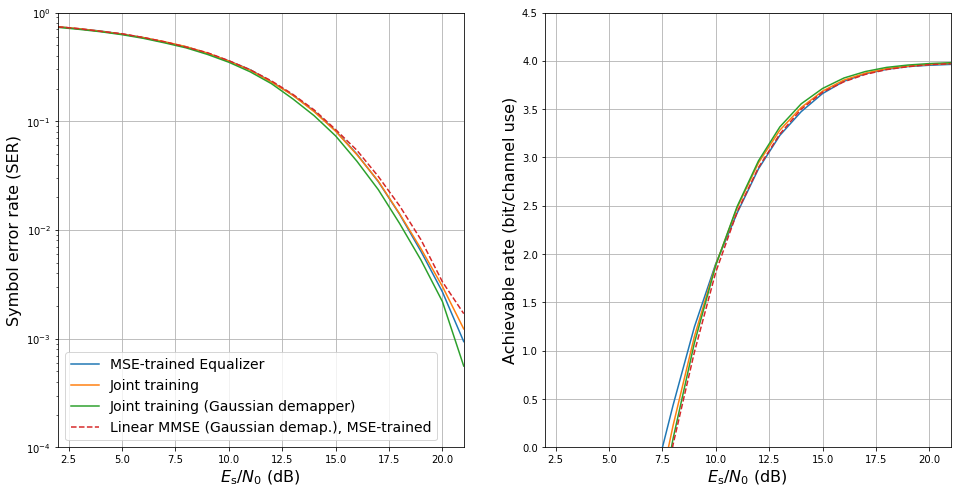

In [39]:
# Evaluate
model_lmeq.eval()
model_lmdemap.eval()

# compute SER and mutual information over a range of EsN0

SER_lm_Gaussian = np.zeros(len(esno_range_eval))
MI_lm_Gaussian = np.zeros(len(esno_range_eval))

for idx,esno in enumerate(esno_range_eval):
    t, _, x, y = prepare_minibatch(constellations[con], h_ch, esno, 100000, seq_length)

    output = model_lmdemap( model_lmeq(y) )   # outputs probabilities
    
    SER_lm_Gaussian[idx] = SER(output.detach().cpu().numpy(), t.detach().cpu().numpy())

    # compute MI
    tmp = output.detach().cpu().numpy()
    MI_lm_Gaussian[idx] = np.log2(len(constellations[con])) - np.mean(-np.log2(tmp[np.arange(tmp.shape[0]),t.detach().long().cpu().numpy()]))
    

   
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.semilogy(esno_range_eval, SER_separate)
plt.semilogy(esno_range_eval, SER_joint)
plt.semilogy(esno_range_eval, SER_joint_Gaussian)
plt.semilogy(esno_range_eval, SER_lm_Gaussian, '--')
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((1e-4, 1))
plt.grid(which='major')
plt.legend(['MSE-trained Equalizer','Joint training', 'Joint training (Gaussian demapper)', 'Linear MMSE (Gaussian demap.), MSE-trained'], fontsize=14)
#plt.title('Equalized constellation',fontsize=16)

plt.subplot(122)
plt.plot(esno_range_eval, MI_separate)
plt.plot(esno_range_eval, MI_joint)
plt.plot(esno_range_eval, MI_joint_Gaussian)
plt.plot(esno_range_eval, MI_lm_Gaussian, '--')
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Achievable rate (bit/channel use)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((0, 4.5))
plt.grid(which='major')
#plt.title('Equalized constellation',fontsize=16)


Joint training of linear MMSE and Gaussian demapper

In [40]:
# Cross Entropy loss accepting logits at input
model_lmjeq = Linear_Equalizer(seq_length*2)
model_lmjeq.to(device)

model_lmjdemap = Gaussian_Demapper(constellations[con])
model_lmjdemap.to(device)

optimizer_lmjeq = optim.Adam( list(model_lmjeq.parameters()) + list(model_lmjdemap.parameters()) )


loss_fn = nn.NLLLoss()


num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

# first train the equalizer
for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        outputs = model_lmjdemap( model_lmjeq(y) )
        
        # compute loss
        loss = loss_fn(torch.log(outputs+0.000000001), t)
        
         # compute gradients
        loss.backward()
        
        optimizer_lmjeq.step()
        
        # reset gradients
        optimizer_lmjeq.zero_grad()
        
    if epoch % 10 == 0:
        print('EQ: Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))
        


EQ: Epoch 0: Loss 1.39521204780820418100973
EQ: Epoch 10: Loss 0.22093698401251349316965
EQ: Epoch 20: Loss 0.19894685725258295927453
EQ: Epoch 30: Loss 0.19453661736271732340953
EQ: Epoch 40: Loss 0.21549595648599850772342
EQ: Epoch 50: Loss 0.21412564383463289496845
EQ: Epoch 60: Loss 0.22780897025390234311715
EQ: Epoch 70: Loss 0.23427739453438450878409
EQ: Epoch 80: Loss 0.21840281425388444191960
EQ: Epoch 90: Loss 0.20846949503386516533432


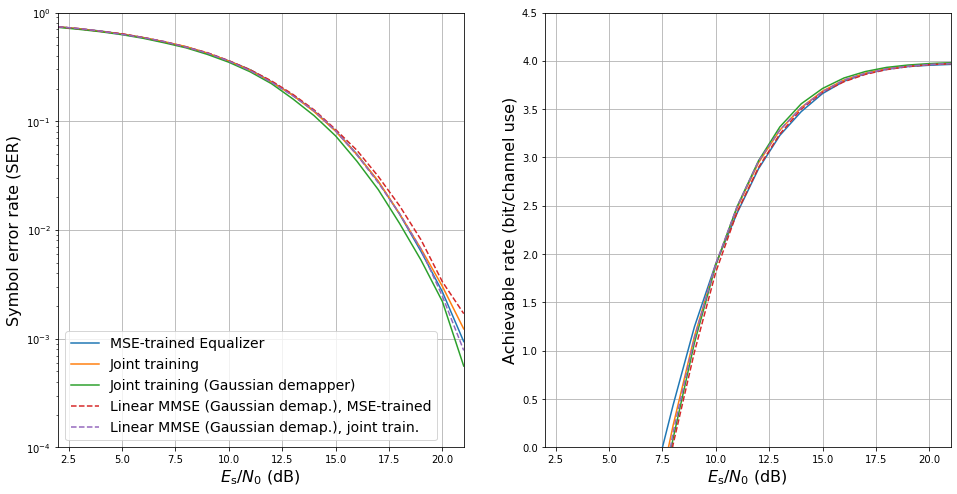

In [41]:
# Evaluate
model_lmjeq.eval()
model_lmjdemap.eval()

# compute SER and mutual information over a range of EsN0

SER_lmj_Gaussian = np.zeros(len(esno_range_eval))
MI_lmj_Gaussian = np.zeros(len(esno_range_eval))

for idx,esno in enumerate(esno_range_eval):
    t, _, x, y = prepare_minibatch(constellations[con], h_ch, esno, 100000, seq_length)

    output = model_lmjdemap( model_lmjeq(y) )   # outputs probabilities
    
    SER_lmj_Gaussian[idx] = SER(output.detach().cpu().numpy(), t.detach().cpu().numpy())

    # compute MI
    tmp = output.detach().cpu().numpy()
    MI_lmj_Gaussian[idx] = np.log2(len(constellations[con])) - np.mean(-np.log2(tmp[np.arange(tmp.shape[0]),t.detach().long().cpu().numpy()]))
    

   
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.semilogy(esno_range_eval, SER_separate)
plt.semilogy(esno_range_eval, SER_joint)
plt.semilogy(esno_range_eval, SER_joint_Gaussian)
plt.semilogy(esno_range_eval, SER_lm_Gaussian, '--')
plt.semilogy(esno_range_eval, SER_lmj_Gaussian, '--')
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((1e-4, 1))
plt.grid(which='major')
plt.legend(['MSE-trained Equalizer','Joint training', 'Joint training (Gaussian demapper)', 'Linear MMSE (Gaussian demap.), MSE-trained', 'Linear MMSE (Gaussian demap.), joint train.'], fontsize=14)
#plt.title('Equalized constellation',fontsize=16)

plt.subplot(122)
plt.plot(esno_range_eval, MI_separate)
plt.plot(esno_range_eval, MI_joint)
plt.plot(esno_range_eval, MI_joint_Gaussian)
plt.plot(esno_range_eval, MI_lm_Gaussian, '--')
plt.plot(esno_range_eval, MI_lmj_Gaussian, '--')
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Achievable rate (bit/channel use)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((0, 4.5))
plt.grid(which='major')
#plt.title('Equalized constellation',fontsize=16)